# Отток клиентов банка

Из банка начали уходить клиенты. Задача - проанализировать исторические данные о поведении клиентов и спрогнозировать уйдёт ли клиент из банка в ближайшее время или нет.

В рамках исследования будем использовать следующие алгоритмы:
- DecisionTreeClassifier
- RandomForestClassifier
- LogisticRegression

Построим модель с предельно большим значением *F1*-меры. Доведем метрику, как минимум, до 0.59. 

Важный момент - присутствует серьезный дисбаланс классов. Обучим модели без учета дисбаланса, а также учитывая особенности наших данных. Применим Upsampling и Downsampling - сравним результаты.

### План решения задачи

* [Шаг 1. Подготовка данных](#1-bullet)
* [Шаг 2. Расчеты без учета дисбаланса](#2-bullet)
* [Шаг 3. Борьба с дисбалансом](#3-bullet)
* [Шаг 4. Тестирование модели](#4-bullet)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

# Шаг 1. Подготовка данных  <a id='1-bullet'></a>

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
print('Размер датасета: ', df.shape)
df.head()

Размер датасета:  (10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# действительно Ли все записи уникальные

len(df.CustomerId.unique())

10000

In [5]:
# посмтрим из каких стран клиенты

df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [6]:
# Здесь есть пропуски - предположим, что пропуски возникли из-за того что недвижимость у клиента отсутствует и заполним нулями
# плюс поменяем формат данных на int

print('Кол-во пропусков:',df.Tenure.isna().sum())
df.Tenure.fillna(0, inplace=True)
print('Кол-во пропусков:',df.Tenure.isna().sum())

Кол-во пропусков: 909
Кол-во пропусков: 0


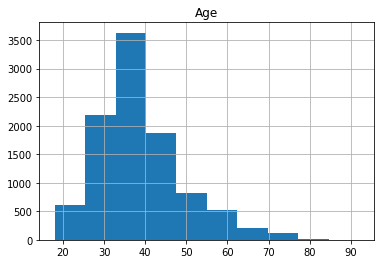

In [7]:
# Посмотрим разброс по возросту

df.hist('Age')
plt.show()

Число клиентов с нулевым балансом:  3617


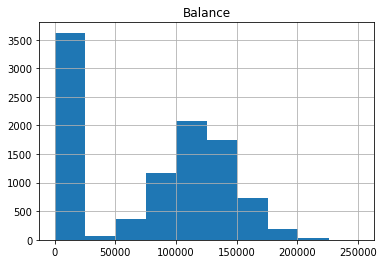

In [8]:
# Посмотрим балансы счетов

print('Число клиентов с нулевым балансом: ', len(df.query('Balance ==0')))

df.hist('Balance')
plt.show()

In [9]:
# На первый взгляд клиенты с нулевым балансом не отличаются от остальных

df.query('Balance ==0').sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4174,4175,15810593,Forbes,568,France,Male,51,4.0,0.0,3,1,1,66586.56,0
7744,7745,15806822,Myers,739,France,Female,36,0.0,0.0,2,0,0,133465.57,0
5667,5668,15719017,Donaldson,672,France,Female,34,8.0,0.0,2,1,1,16245.25,0
1209,1210,15715667,Sorokina,850,France,Female,32,7.0,0.0,2,0,0,155227.00,0
1484,1485,15607713,Kaeppel,850,Spain,Female,29,1.0,0.0,2,1,1,197996.65,0


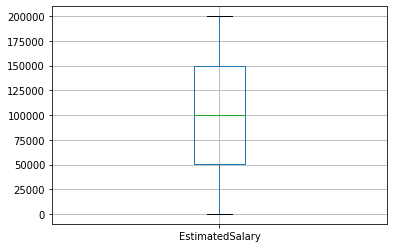

In [10]:
# По всей видимости зарплата расчитывалась на основании другой модели, а не заполнялась вручную

df.boxplot('EstimatedSalary')
plt.show()

In [11]:
# Эти признаки нам не понадобятся, так как они не имеют предсказательной силы - удалим

extra_features = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(extra_features, axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


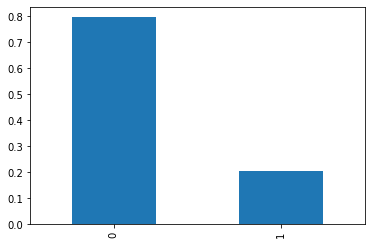

In [12]:
# Целевой признак не сбалансирован (80% против 20%) - необходимо иметь это ввиду

df.Exited.value_counts(normalize=True).plot(kind='bar')

Промежуточные итоги:
- в датасете представлены клиенты из трех стран: Франция (50%), Германия (25%) и Испания (25%)
- присутствует много сетов нулевым балансом, но это абсолютно нормально, например, клиент может получать зарплату и переводить на другой счет или вносить раз в месяц плату по ипотеке
- удалили лишние фичи, которые могут помешать анализу RowNumber, CustomerId, Surname
- выяснили, что объектов нулевого класса в 4 раза больше, чем первого

# 2. Модели без учета дисбаланса <a id='2-bullet'></a>

Для начала построим модели без учета дисбаланса

In [13]:
# Для автоматизации процесса объявим несколько функций

rnd_state = 222

def tf(df, target_column='Exited'):     # облегчим процесс вычленения таргета
    target = df[target_column]
    features = df.drop(target_column, axis=1)
    return target, features

In [14]:
# Все по методичке: 60% на обучающую выборку, 20% на валидационную и 20% на тестовую
# Плюс будем масштабировать количественные признаки

def split_data(features, target):

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=rnd_state)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=rnd_state)
    
    scaler = StandardScaler()
    numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [15]:
# Учтем, что надо эксперементировать с upsample и downsample, рассчитывать f-1 меру

def train_and_predict(df, model, prefix='', samplefunc=None):

    target, features = tf(df)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{prefix}F1-мера на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    print(f'{prefix}ROC-AUC на валидационной выборке: {roc_auc_score(target_test, probabilities_one_test)}')
    
    print('') 
    
    return model

### Логистическая регрессия

In [16]:
df_ohe = pd.get_dummies(df, drop_first=True)
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(df_ohe, model)

F1-мера на валидационной выборке: 0.3174061433447099
ROC-AUC на валидационной выборке: 0.7673650083985729



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=222, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Дерево классификации

In [17]:
encoder = OrdinalEncoder()
df[["Geography","Gender", "HasCrCard", "IsActiveMember", "Exited"]] = encoder.fit_transform(
    df[["Geography","Gender", "HasCrCard", "IsActiveMember", "Exited"]])


for max_depth in range(2, 21, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(df, model, prefix=f'{max_depth}:\t')     

2:	F1-мера на валидационной выборке: 0.5217391304347826
2:	ROC-AUC на валидационной выборке: 0.7542795151526537

4:	F1-мера на валидационной выборке: 0.4088397790055249
4:	ROC-AUC на валидационной выборке: 0.822755671189216

6:	F1-мера на валидационной выборке: 0.5497896213183732
6:	ROC-AUC на валидационной выборке: 0.831547168984297

8:	F1-мера на валидационной выборке: 0.5470085470085471
8:	ROC-AUC на валидационной выборке: 0.8181579808359124

10:	F1-мера на валидационной выборке: 0.5132275132275133
10:	ROC-AUC на валидационной выборке: 0.7521732188059156

12:	F1-мера на валидационной выборке: 0.4916773367477592
12:	ROC-AUC на валидационной выборке: 0.7138794832177258

14:	F1-мера на валидационной выборке: 0.473876063183475
14:	ROC-AUC на валидационной выборке: 0.6942019320631372

16:	F1-мера на валидационной выборке: 0.46407538280329796
16:	ROC-AUC на валидационной выборке: 0.6856718623541991

18:	F1-мера на валидационной выборке: 0.46543778801843316
18:	ROC-AUC на валидационной выб

Лучшая F1 мера у дерева глубиной - 6: 0.5497

### Случайный лес

In [18]:
# Лучшую глубину мы уже нашли, так что вписываем ее

for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(df, model, prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.512987012987013
n_estimators = 10:	ROC-AUC на валидационной выборке: 0.8454482552414766

n_estimators = 20:	F1-мера на валидационной выборке: 0.5032679738562091
n_estimators = 20:	ROC-AUC на валидационной выборке: 0.8482910899985754

n_estimators = 30:	F1-мера на валидационной выборке: 0.5032258064516129
n_estimators = 30:	ROC-AUC на валидационной выборке: 0.848888304458836

n_estimators = 40:	F1-мера на валидационной выборке: 0.5136436597110755
n_estimators = 40:	ROC-AUC на валидационной выборке: 0.8495661389576376

n_estimators = 50:	F1-мера на валидационной выборке: 0.512
n_estimators = 50:	ROC-AUC на валидационной выборке: 0.8495043041707957

n_estimators = 60:	F1-мера на валидационной выборке: 0.5136436597110755
n_estimators = 60:	ROC-AUC на валидационной выборке: 0.8494510792909821

n_estimators = 70:	F1-мера на валидационной выборке: 0.5176848874598071
n_estimators = 70:	ROC-AUC на валидационной выборке: 0.8506173303339547



Лучший результат - n_estimators = 150: 0.5217

Результаты должны оказаться лучше после того как мы разберемся с дисбалансом

# 3. Борьба с дисбалансом <a id='3-bullet'></a>

Сначала применим гиперпараметр class_weight='balanced'

### Логистическая регрессия

In [19]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=rnd_state)
train_and_predict(df_ohe, model)

F1-мера на валидационной выборке: 0.49486301369863006
ROC-AUC на валидационной выборке: 0.7718014586747944



LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=222, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Дерево классификации

In [20]:
for max_depth in range(2, 21, 2):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=max_depth, random_state=rnd_state)
    train_and_predict(df, model, prefix=f'{max_depth}:\t')     

2:	F1-мера на валидационной выборке: 0.5052631578947369
2:	ROC-AUC на валидационной выборке: 0.7542795151526537

4:	F1-мера на валидационной выборке: 0.5571293673276675
4:	ROC-AUC на валидационной выборке: 0.8247602140892518

6:	F1-мера на валидационной выборке: 0.5552654482158398
6:	ROC-AUC на валидационной выборке: 0.8263514814519121

8:	F1-мера на валидационной выборке: 0.5479704797047971
8:	ROC-AUC на валидационной выборке: 0.7901609113351774

10:	F1-мера на валидационной выборке: 0.5219780219780219
10:	ROC-AUC на валидационной выборке: 0.7514186778626767

12:	F1-мера на валидационной выборке: 0.5061224489795918
12:	ROC-AUC на валидационной выборке: 0.7076764365629877

14:	F1-мера на валидационной выборке: 0.504875406283857
14:	ROC-AUC на валидационной выборке: 0.694106440367001

16:	F1-мера на валидационной выборке: 0.4831460674157303
16:	ROC-AUC на валидационной выборке: 0.6963567569767641

18:	F1-мера на валидационной выборке: 0.4877479579929988
18:	ROC-AUC на валидационной выбо

### Случайный лес

In [21]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=estim, max_depth=4, random_state=rnd_state)
    train_and_predict(df, model, prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5807127882599581
n_estimators = 10:	ROC-AUC на валидационной выборке: 0.8415448364822111

n_estimators = 20:	F1-мера на валидационной выборке: 0.5659229208924949
n_estimators = 20:	ROC-AUC на валидационной выборке: 0.841406295250932

n_estimators = 30:	F1-мера на валидационной выборке: 0.5784114052953158
n_estimators = 30:	ROC-AUC на валидационной выборке: 0.8417827830037304

n_estimators = 40:	F1-мера на валидационной выборке: 0.5697091273821465
n_estimators = 40:	ROC-AUC на валидационной выборке: 0.8419041044209525

n_estimators = 50:	F1-мера на валидационной выборке: 0.5725567620927937
n_estimators = 50:	ROC-AUC на валидационной выборке: 0.8429052017927391

n_estimators = 60:	F1-мера на валидационной выборке: 0.5680705190989226
n_estimators = 60:	ROC-AUC на валидационной выборке: 0.8436973132393758

n_estimators = 70:	F1-мера на валидационной выборке: 0.5703048180924287
n_estimators = 70:	ROC-AUC на валидационной выборке: 0.8443

### Результаты

- можно заменить улучшение по логистической регрессии (0.4864 против 0.3047) 
- по дереву - 0.5571 против 0.5497
- случайный лес показал наилучший результат - 0.5807 против 0.5217 


## Upsample

In [22]:
# Функция для увеличения числа объектов редкого класса

def upsample(features, target, repeat=4):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rnd_state)
    
    return features_upsampled, target_upsampled

### Логистическая регрессия

In [23]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(df_ohe, model, samplefunc=upsample)

F1-мера на валидационной выборке: 0.49199663016006745
ROC-AUC на валидационной выборке: 0.7718390291781922



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=222, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Дерево классификации

In [24]:
for max_depth in range(2, 25, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(df, model, samplefunc=upsample, prefix=f'{max_depth}:\t')     

2:	F1-мера на валидационной выборке: 0.5052631578947369
2:	ROC-AUC на валидационной выборке: 0.7542795151526537

4:	F1-мера на валидационной выборке: 0.5571293673276675
4:	ROC-AUC на валидационной выборке: 0.8247602140892518

6:	F1-мера на валидационной выборке: 0.5557491289198606
6:	ROC-AUC на валидационной выборке: 0.8259867344814253

8:	F1-мера на валидационной выборке: 0.5514705882352942
8:	ROC-AUC на валидационной выборке: 0.7919776017182243

10:	F1-мера на валидационной выборке: 0.5279560036663611
10:	ROC-AUC на валидационной выборке: 0.7570714731864013

12:	F1-мера на валидационной выборке: 0.5071283095723014
12:	ROC-AUC на валидационной выборке: 0.7241792801804636

14:	F1-мера на валидационной выборке: 0.5
14:	ROC-AUC на валидационной выборке: 0.7084372392567927

16:	F1-мера на валидационной выборке: 0.4819004524886878
16:	ROC-AUC на валидационной выборке: 0.6923390612696639

18:	F1-мера на валидационной выборке: 0.48300117233294254
18:	ROC-AUC на валидационной выборке: 0.69680

### Случайный лес

In [25]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=4, random_state=rnd_state)
    train_and_predict(df, model, samplefunc=upsample, prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5590955806783146
n_estimators = 10:	ROC-AUC на валидационной выборке: 0.8438006321237197

n_estimators = 20:	F1-мера на валидационной выборке: 0.5625
n_estimators = 20:	ROC-AUC на валидационной выборке: 0.8374590442377023

n_estimators = 30:	F1-мера на валидационной выборке: 0.5645004849660523
n_estimators = 30:	ROC-AUC на валидационной выборке: 0.8379325891242785

n_estimators = 40:	F1-мера на валидационной выборке: 0.5586808923375364
n_estimators = 40:	ROC-AUC на валидационной выборке: 0.8387818390448325

n_estimators = 50:	F1-мера на валидационной выборке: 0.5617103984450923
n_estimators = 50:	ROC-AUC на валидационной выборке: 0.8403997188473997

n_estimators = 60:	F1-мера на валидационной выборке: 0.5605338417540515
n_estimators = 60:	ROC-AUC на валидационной выборке: 0.8409304022078932

n_estimators = 70:	F1-мера на валидационной выборке: 0.563758389261745
n_estimators = 70:	ROC-AUC на валидационной выборке: 0.8422735477043639

Результаты у регрессии и дерева стали немного лучше, но случайный лес стал работать хуже

## Downsample

In [26]:
def downsample(features, target, fraction = 0.25):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=rnd_state)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=rnd_state)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rnd_state)
    
    return features_downsampled, target_downsampled

### Логистическая регрессия

In [27]:
model = LogisticRegression(solver='liblinear', random_state=rnd_state)
train_and_predict(df_ohe, model, samplefunc=downsample)

F1-мера на валидационной выборке: 0.4914965986394558
ROC-AUC на валидационной выборке: 0.7681007640901127



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=222, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Дерево классификации

In [28]:
for max_depth in range(2, 21, 2):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=rnd_state)
    train_and_predict(df, model, samplefunc=downsample, prefix=f'{max_depth}:\t')     

2:	F1-мера на валидационной выборке: 0.504941599281222
2:	ROC-AUC на валидационной выборке: 0.7581453634085212

4:	F1-мера на валидационной выборке: 0.4981412639405204
4:	ROC-AUC на валидационной выборке: 0.8181133658631274

6:	F1-мера на валидационной выборке: 0.5452976704055219
6:	ROC-AUC на валидационной выборке: 0.8272915267556774

8:	F1-мера на валидационной выборке: 0.5237288135593221
8:	ROC-AUC на валидационной выборке: 0.8050623122453229

10:	F1-мера на валидационной выборке: 0.5058430717863105
10:	ROC-AUC на валидационной выборке: 0.7477046770580418

12:	F1-мера на валидационной выборке: 0.4889615699100572
12:	ROC-AUC на валидационной выборке: 0.7191401364122361

14:	F1-мера на валидационной выборке: 0.47749196141479106
14:	ROC-AUC на валидационной выборке: 0.6967770769835269

16:	F1-мера на валидационной выборке: 0.47850770478507704
16:	ROC-AUC на валидационной выборке: 0.7052758379396336

18:	F1-мера на валидационной выборке: 0.4803212851405622
18:	ROC-AUC на валидационной в

### Случайный лес

In [29]:
for estim in range(10, 221, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=6, random_state=rnd_state)
    train_and_predict(df, model, samplefunc=downsample, prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-мера на валидационной выборке: 0.5620915032679739
n_estimators = 10:	ROC-AUC на валидационной выборке: 0.8484491992003744

n_estimators = 20:	F1-мера на валидационной выборке: 0.5577617328519855
n_estimators = 20:	ROC-AUC на валидационной выборке: 0.8484311966674963

n_estimators = 30:	F1-мера на валидационной выборке: 0.5626740947075208
n_estimators = 30:	ROC-AUC на валидационной выборке: 0.8464736168967077

n_estimators = 40:	F1-мера на валидационной выборке: 0.5700846660395108
n_estimators = 40:	ROC-AUC на валидационной выборке: 0.8471248389556026

n_estimators = 50:	F1-мера на валидационной выборке: 0.5687732342007434
n_estimators = 50:	ROC-AUC на валидационной выборке: 0.8475991665609997

n_estimators = 60:	F1-мера на валидационной выборке: 0.5724907063197026
n_estimators = 60:	ROC-AUC на валидационной выборке: 0.8488483857989757

n_estimators = 70:	F1-мера на валидационной выборке: 0.5764925373134328
n_estimators = 70:	ROC-AUC на валидационной выборке: 0.849

Уменьшение выборки привело к немного более слабым результатам у дерева. Что касается регресси и случайного леса, то они стали работать немного лучше, чем при балансировке и upsample

# 4. Тестирование модели <a id='4-bullet'></a>

В ходе экспериментов мы выяснили, что лучше всего для наших целей использовать модель "Случайный лес" с n_estimators=200, max_depth=7 и downsample

In [30]:
target, features = tf(df)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
features_downsampled, target_downsampled = downsample(features_train, target_train)

model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=rnd_state)
model.fit(features_downsampled, target_downsampled)

predicted_test = model.predict(features_test)
print('Результат теста downsample:', f1_score(target_test, predicted_test))

Результат теста downsample: 0.5918173168411037


In [31]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

roc_auc_score(target_test, probabilities_one_test)

0.851068959093549

Требования заказчика по значению *F1*-меры выполнено